# Система прогнозирования покупательской активности и персонализации предложений интернет-магазина

**Цель:**

Интернет-магазин "В один клик" обнаружил снижение покупательной активности постоянных клиентов. Для ее удержания решили построить систему персональных предложений для сегмента постоянных покупателей. Для реализации этой задачи необходимо:
+ построить модель, прогнозирующую вероятность снижения покупательской активности клиента в следующие три месяца;
+ разработать персонализированные предложения для клиентов разных сегментов прибыльности.

**Описание данных:**  
*Данные о поведении покупателя на сайте:*
+ id — номер покупателя в корпоративной базе данных.
+ Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
+ Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
+ Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
+ Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
+ Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
+ Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
+ Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
+ Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
+ Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
+ Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
+ Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
+ Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

*Данные о выручке:*
+ id — номер покупателя в корпоративной базе данных.
+ Период — название периода, во время которого зафиксирована выручка. Например,
'текущий_месяц' или 'предыдущий_месяц'.
+ Выручка — сумма выручки за период.

*Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:*

+ id — номер покупателя в корпоративной базе данных.
+ Период — название периода, во время которого зафиксировано общее время.
+ минут — значение времени, проведённого на сайте, в минутах.

*Данные о среднемесячной прибыли покупателя за последние 3 месяца:*
+ id — номер покупателя в корпоративной базе данных.
+ Прибыль — значение прибыли.

**Файлы:**

**market_file.csv** - данные о поведении покупателя на сайте;  
**market_money.csv** - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.  
**market_time.csv** - Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
**money.csv** - Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**План исследования:**
1. Загрузка и предпросмотр данных
2. Предобработка данных
3. Исследователский анализ
4. Выбор и построение модели
5. Интерпретация
6. Сегментация покупателей и рекомендации сегментам


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍 Контекст и план проекта понятны.
</div>  


**Импорт библиотек:**

In [1]:
import pandas as pd
!pip install matplotlib==3.5 -q
import matplotlib.pyplot as plt
import numpy as np
!pip install phik -q
import phik
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
!pip install scikit-learn==1.6 -q
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
!pip install shap -q
import shap

 <div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
 
Отлично по оформлению, но важно поправить порядок:
    
Сначала мы устанавливаем что-то: `!pip install matplotlib==3.5 -q` - в этой команде происходит скачивание пакета из интернета и установка его в виртуальной машине (или на компьютере).
    
А при import пакет уже устанавливается в нашу виртуальную среду. 
    
Нельзя сначала отрыть приложение, а затем скачать. (конкретно выше ошибки может не быть, так как matplotlib у нас предустановлен. Но если важно загрузить именно версию 3.5, то нужно сначала сделать install, затем import.

## Загрузка и предпросмотр данных

In [2]:
# функция для создания датафрейма
def read_data(f_path, link, separator, decimal='.'):

    try:
        data = pd.read_csv(f_path, sep=separator, decimal=decimal)
    except:
        data = pd.read_csv(link, sep=separator, decimal=decimal)

    return data

In [3]:
# считываем в датафрейм
df_market_file = read_data('/datasets/market_file.csv',
                           'https://code.s3.yandex.net/datasets/market_file.csv',
                           ',')
df_market_money = read_data('/datasets/market_money.csv',
                            'https://code.s3.yandex.net/datasets/market_money.csv',
                            ',')
df_market_time = read_data('/datasets/market_time.csv',
                           'https://code.s3.yandex.net/datasets/market_time.csv',
                           ',')
df_money = read_data('/datasets/money.csv',
                     'https://code.s3.yandex.net/datasets/money.csv',
                     ';', ',')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично, что указываешь разделитель с запятой для чисел.
</div> 


In [4]:
# функция для ознакомления с таблицами
def observe_data(df):
    print('Превью таблицы (первые пять строк):\n')
    display(df.head())
    print('=' * 90)
    print('Информация о столбцах и типах данных:\n')
    display(df.info())
    print('=' * 90)
    print('Статистическая информация:\n')
    display(df.describe().T)

In [5]:
data_frames = [df_market_file, df_market_money, df_market_time, df_money]
for df in data_frames:
    observe_data(df)

Превью таблицы (первые пять строк):



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int6

None

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.0,215672.75,215997.50,216322.25,216647.00
Маркет_актив_6_мес,1300.0,4.253769,1.014814,0.9,3.70,4.20,4.90,6.60
Маркет_актив_тек_мес,1300.0,4.011538,0.696868,3.0,4.00,4.00,4.00,5.00
Длительность,1300.0,601.898462,249.856289,110.0,405.50,606.00,806.00,1079.00
Акционные_покупки,1300.0,0.319808,0.249843,0.0,0.17,0.24,0.30,0.99
Средний_просмотр_категорий_за_визит,1300.0,3.270000,1.355350,1.0,2.00,3.00,4.00,6.00
Неоплаченные_продукты_штук_квартал,1300.0,2.840000,1.971451,0.0,1.00,3.00,4.00,10.00
Ошибка_сервиса,1300.0,4.185385,1.955298,0.0,3.00,4.00,6.00,9.00
Страниц_за_визит,1300.0,8.176923,3.978126,1.0,5.00,8.00,11.00,20.00


Превью таблицы (первые пять строк):



,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,3900.0,215997.500000,375.325686,215348.0,215672.75,215997.5,216322.25,216647.0
Выручка,3900.0,5025.696051,1777.704104,0.0,4590.15,4957.5,5363.00,106862.2


Превью таблицы (первые пять строк):



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,2600.0,215997.500000,375.349754,215348.0,215672.75,215997.5,216322.25,216647.0
минут,2600.0,13.336154,4.080198,4.0,10.00,13.0,16.00,23.0


Превью таблицы (первые пять строк):



,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Информация о столбцах и типах данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
id,1300.0,215997.500000,375.421985,215348.00,215672.75,215997.500,216322.25,216647.00
Прибыль,1300.0,3.996631,1.013722,0.86,3.30,4.045,4.67,7.43


**Вывод:**
краткое превью по таблицам:
+ `df_market_file`: таблица имеет 1300 строк и 13 столбцов. Предварительно выявлены некоторые проблемы: 
    + названия столбцов не соответсвуют принятым нормам(верхний регистр, кириллица, пробелы);
    + неверный тип данных.
+ `df_market_money`: структура таблицы - 3900 строк и 3 столбца. Выявленные проблемы:
    + названия столбцов не соответствуют принятым нормам(верхний регистр, кириллица)
+ `df_market_time`: таблица состоит из 2900 строк и 3 столбцов. Проблемы имеются в названии столбцов и категорий.
+ `df_money`: аблица имеет 1300 строк и 2 столбца. Есть проблемы в названии столбца.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Все верно по первому знакомству с данными.
</div> 


## Предобработка данных

Исправим последовательно все выявленные недочеты.

### df_market_file

Хотя и можно оставить кириллические символы, но чтобы не было перемешиваний с латинскими названиями, и потому что английские названия лаконичнее, заменим названия всех столбцов, попутно избавляясь от пробелов и верхнего ригистра. 

In [6]:
# запишем сразу новые названия столбцов первой таблицы
df_market_file.columns = [
    'id',
    'cons_activity',
    'service_type',
    'offers_allow',
    'avg_marketing_activity_6_m',
    'avg_marketing_activity_cur_m',
    'days_registered',
    'promo_purchase_rate',
    'favorite_category',
    'categories_viewed_per_visit',
    'unpaid_items_last_3_m',
    'service_error',
    'pages_per_visit_last_3_m'
]
df_market_file.head(2)

,id,cons_activity,service_type,offers_allow,avg_marketing_activity_6_m,avg_marketing_activity_cur_m,days_registered,promo_purchase_rate,favorite_category,categories_viewed_per_visit,unpaid_items_last_3_m,service_error,pages_per_visit_last_3_m
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5


Во всех численных признаках не ожидается больших значений, поэтому можем перевести в `int32`.

In [7]:
columns_to_change = df_market_file.select_dtypes(include='int64').columns
df_market_file[columns_to_change] = df_market_file[columns_to_change].astype('int32')

In [8]:
df_market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1300 non-null   int32  
 1   cons_activity                 1300 non-null   object 
 2   service_type                  1300 non-null   object 
 3   offers_allow                  1300 non-null   object 
 4   avg_marketing_activity_6_m    1300 non-null   float64
 5   avg_marketing_activity_cur_m  1300 non-null   int32  
 6   days_registered               1300 non-null   int32  
 7   promo_purchase_rate           1300 non-null   float64
 8   favorite_category             1300 non-null   object 
 9   categories_viewed_per_visit   1300 non-null   int32  
 10  unpaid_items_last_3_m         1300 non-null   int32  
 11  service_error                 1300 non-null   int32  
 12  pages_per_visit_last_3_m      1300 non-null   int32  
dtypes: 

In [9]:
# проверим на явные дубли
df_market_file.duplicated().sum()

0

In [10]:
# проверим на неявные дубли
for column in df_market_file.select_dtypes(include='object').columns:
    print(f'Column: {column}, names: {df_market_file[column].unique()}')

Column: cons_activity, names: ['Снизилась' 'Прежний уровень']
Column: service_type, names: ['премиум' 'стандартт' 'стандарт']
Column: offers_allow, names: ['да' 'нет']
Column: favorite_category, names: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [11]:
# устраним опечатку в названии
df_market_file.loc[df_market_file['service_type'] == 'стандартт', 'service_type'] = 'стандарт'
df_market_file['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

### Датасет df_market_money

In [12]:
# исправим названия колонок
df_market_money.columns = [
    'id',
    'period',
    'revenue'
]
df_market_money.head(2)

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1


In [13]:
# переведем в int32
df_market_money['id'] = df_market_money['id'].astype('int32')
df_market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int32  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int32(1), object(1)
memory usage: 76.3+ KB


In [14]:
# проверим на явные дубли
df_market_money.duplicated().sum()

0

In [15]:
# проверим на неявные дубли
df_market_money['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

### Датасет df_market_time

In [16]:
# исправим названия колонок
df_market_time.columns = [
    'id',
    'period',
    'minutes'
]
df_market_time.head(2)

,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13


In [17]:
# переведем в int32
df_market_time[['minutes', 'id']] = df_market_time[['minutes', 'id']].astype('int32')
df_market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int32 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 40.8+ KB


In [18]:
# проверим на явные дубли
df_market_time.duplicated().sum()

0

In [19]:
# проверим на неявные дубли
df_market_time['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [20]:
# исправим опечатку в категории
df_market_time.loc[df_market_time['period'] == 'предыдцщий_месяц', 'period'] = 'предыдyщий_месяц'
df_market_time['period'].unique()

array(['текущий_месяц', 'предыдyщий_месяц'], dtype=object)

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично
</div> 


### Датасет df_money

In [21]:
# исправим названия колонок
df_money.columns = [
    'id',
    'profit'
]
df_money.head(2)

,id,profit
0,215348,0.98
1,215349,4.16


In [22]:
# переведем в int32
df_money['id'] = df_money['id'].astype('int32') 
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int32  
 1   profit  1300 non-null   float64
dtypes: float64(1), int32(1)
memory usage: 15.4 KB


**Вывод:** Выявленные недочеты устранены, опечатки в названиях категорий исправлены. Все готово для дальнейшего исследования.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Ок, двигаемся дальше!

## Исследовательский анализ данных

### Статистический анализ

Изучим количественные данные первой таблицы. Для этого построим гистограмму распределения и оценим наличие выбросов с помощью боксплота.

In [23]:
df_market_file.select_dtypes(exclude='object').drop('id', axis=1).head(2)

,avg_marketing_activity_6_m,avg_marketing_activity_cur_m,days_registered,promo_purchase_rate,categories_viewed_per_visit,unpaid_items_last_3_m,service_error,pages_per_visit_last_3_m
0,3.4,5,121,0.00,6,2,1,5
1,4.4,4,819,0.75,4,4,2,5


In [24]:
def plot_graph(column):
    """
     Функция строит гистограмму и боксплот. 
        На входе принимает столбец с данными.
    """
    # найдем среднее и медиану
    mean = column.mean()
    median = column.median()

    # строим фигуру
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # строим гистограмму
    axs[0].hist(column, bins=30)
    axs[0].axvline(x=mean, ymin=0, ymax=1, color='red', label='Среднее')
    axs[0].axvline(x=median, ymin=0, ymax=1, color='blue', label='Медиана')

    # подписи к гистограмме
    axs[0].set_title(f'Гистограмма распределения признака {column.name}')
    axs[0].set_xlabel(column.name)
    axs[0].set_ylabel('Количество')
    axs[0].legend()
    axs[0].grid(True)

    # строим боксплот
    axs[1].boxplot(column, vert=True)

    # делаем подписи
    axs[1].set_title(f'Боксплот признака {column.name}')
    axs[1].set_xlabel(column.name)
    axs[1].grid(True)

    # выравниваем
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)

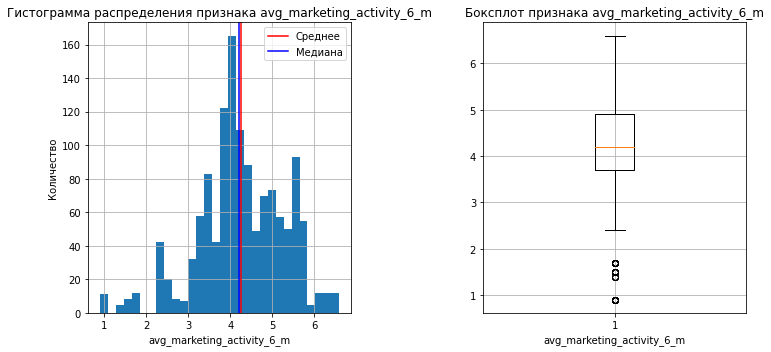

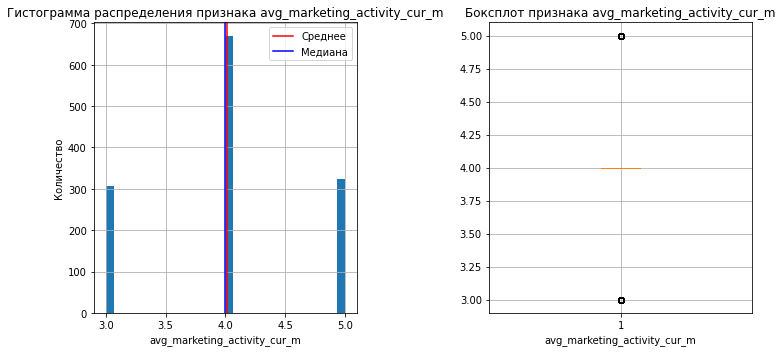

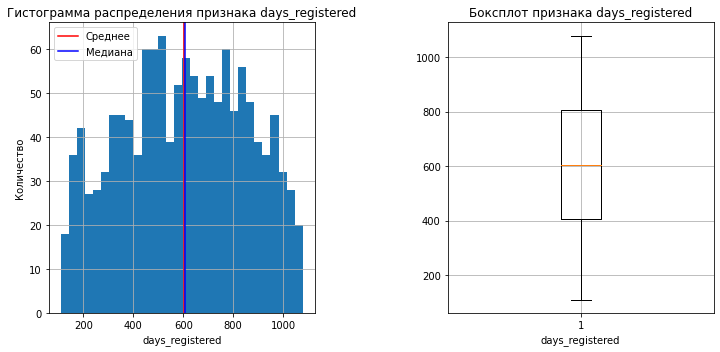

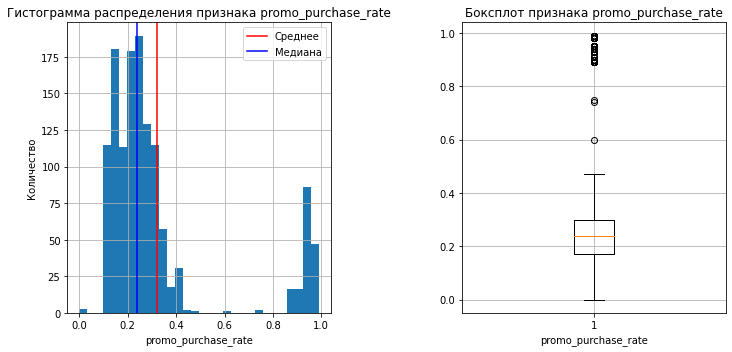

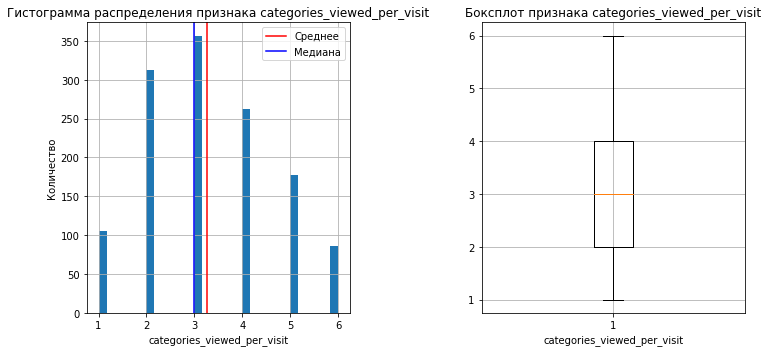

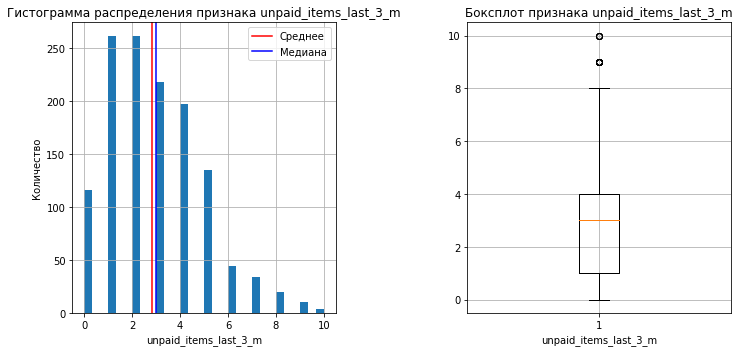

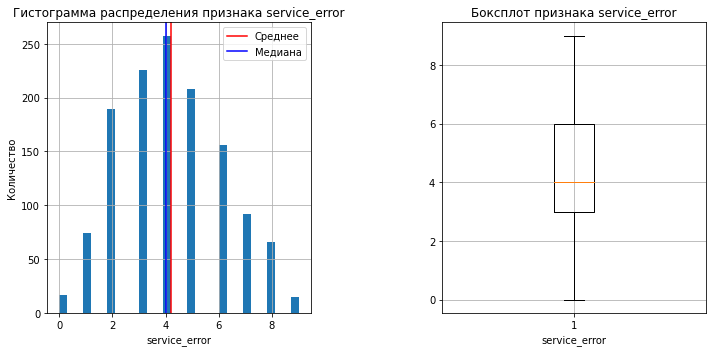

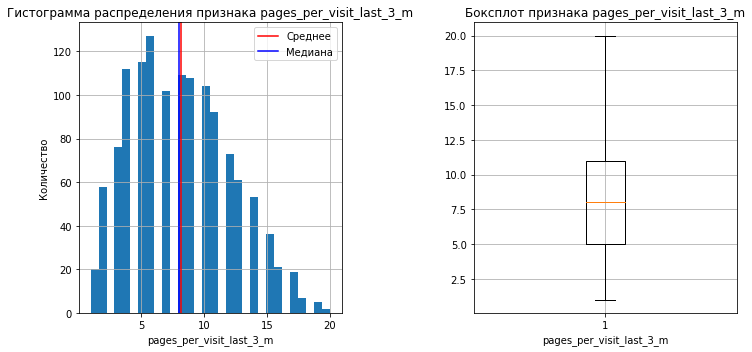

In [25]:

for column in df_market_file.select_dtypes(exclude='object').drop('id', axis=1).columns:
    plot_graph(df_market_file[column])

Значения во всех количественных признаках нормально распределены, есть с перекосами (`promo_purchase_rate`, `unpaid_items_last_3_m`). Отмечаем наличие выбросов в некоторых признаках: `avg_marketing_activity_6_m`, `promo_purchase_rate`, `unpaid_items_last_3_m`.

Посмотрим, как распределяются бинарные категориальные данные. Построим диаграмму для подобных признаков.

In [26]:
def make_pie_plot(df, column):
    ''' Функция строит диаграмму. 
        На входе принимает датафрейм и название столбец с данными, 
        на которых надо построить график. '''
    
    labels = df[column].unique()
    sizes = df[column].value_counts()

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.pie(sizes[labels], labels=labels, autopct='%1.1f%%',
           pctdistance=1.15, labeldistance=.3)
    ax.set_title(f'Соотношение в столбце {column}')
    
    plt.tight_layout()
    plt.show()

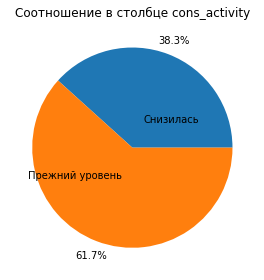

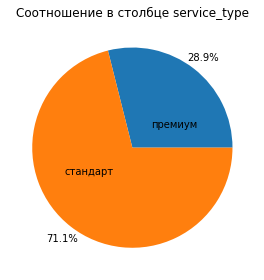

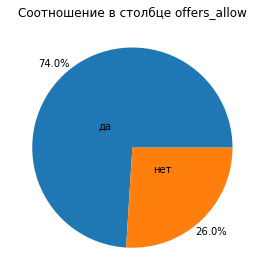

In [27]:
for column in df_market_file.select_dtypes(include='object').drop('favorite_category', axis=1):
    make_pie_plot(df_market_file, column)

Значения целевого признака `cons_activity` распределены неравномерно: пользователей со сниженной активностью в 1.6 меньше. Также значительно больше пользователей, пользующихся стандарт сервисом и тех, кто разрешил рекламные рассылки.

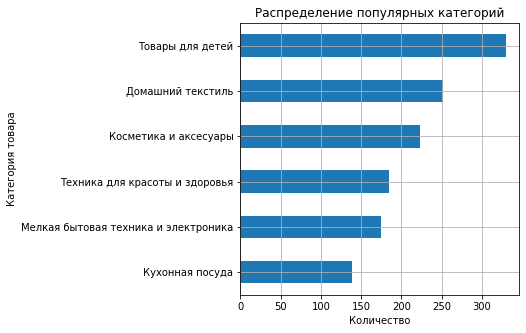

In [28]:
# строим гистограмму распределения популярных категорий
(df_market_file['favorite_category']
    .value_counts()
    .sort_values()
    .plot(kind='barh', figsize=(5, 5))
 )
plt.title('Распределение популярных категорий')
plt.ylabel('Категория товара')
plt.xlabel('Количество')
plt.grid(True)
plt.show()

Топ-3 категорий товаров: *товары для детей*, *домашний текстиль*, *косметика и аксессуары*.

**Датасет df_market_money**

In [29]:
df_market_money.groupby(
    'period')['revenue'].median().sort_values(ascending=False)

period
текущий_месяц          5179.95
предыдущий_месяц       5005.00
препредыдущий_месяц    4809.00
Name: revenue, dtype: float64

Медианное значение выручки говорит о том, что траты клиентов возрастают месяц от месяца, приближаясь к текущему.

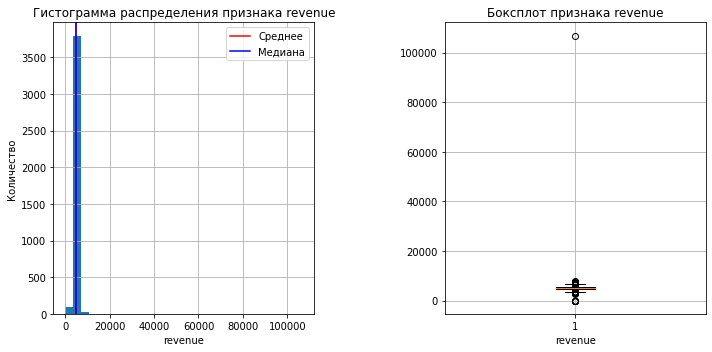

In [30]:
# построим гистограмму и боксплот
plot_graph(df_market_money['revenue'])

Получилось непрезентабельно из-за аномальных значений.

In [31]:
df_market_money['revenue'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

In [32]:
len(df_market_money[df_market_money['revenue'] > 10000])

1

Такое значение всего одно, заменим его на медианное и снова построим графики.

In [33]:
df_market_money.loc[df_market_money['revenue'] > 10000, 'revenue'] = df_market_money['revenue'].median()

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
 
👍  Хорошее решение. Отлично, что везде оставляешь комментарии и аргументацию.
</div>   


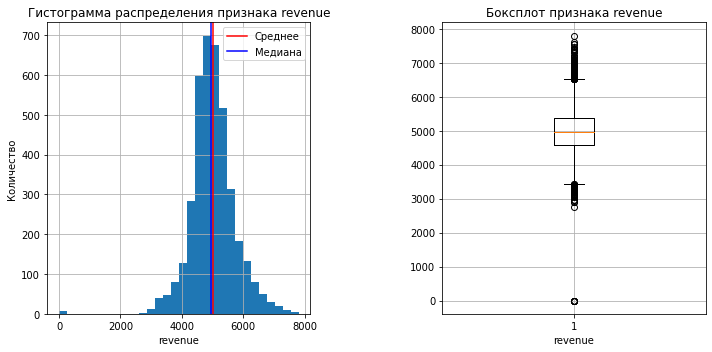

In [34]:
plot_graph(df_market_money['revenue'])

Теперь видим, что выручка с клиентов тоже нормально распределена и имеет выбросы. Также видим околонулевую выручку, посмотрим подробнее.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Обрати внимание, по заданию проекта нужно убрать именно клиентов с нулевой выручкой в любом из периодов.
    
С точки зрения аналитики нет ничего подозрительного, что клиент потратил мало денег (около нуля). 

</div> 

In [35]:
df_market_money.query('revenue < 1000')

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [36]:
df_market_money[df_market_money['id'].isin([215348, 215357, 215359])]

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
27,215357,текущий_месяц,5986.3
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
33,215359,текущий_месяц,4735.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Эти клиенты совершали покупки только в последний месяц.

In [37]:
df_market_money_non_zero = df_market_money.loc[df_market_money['revenue'] == 0]
df_market_money_non_zero.tail()

,id,period,revenue
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


**Датасет df_market_time**

In [38]:
df_market_time.groupby('period')['minutes'].mean()

period
предыдyщий_месяц    13.467692
текущий_месяц       13.204615
Name: minutes, dtype: float64

В среднем клиенты в предыдущий месяц посещали сайт на четверть минуты дольше.

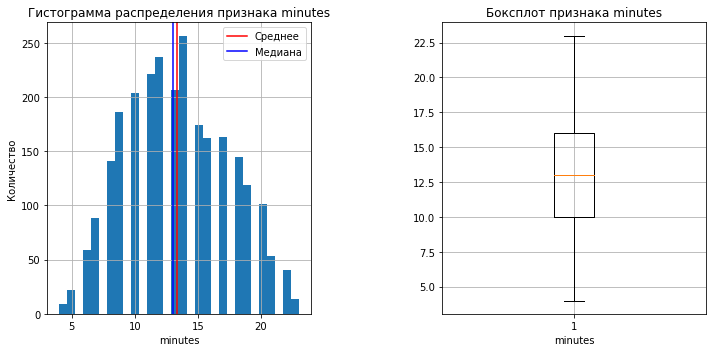

In [39]:
# построим гистограмму и боксплот
plot_graph(df_market_time['minutes'])

Продолжительность посещения сервиса распределено нормально, не имеет выбросов.

**Датасет df_money**

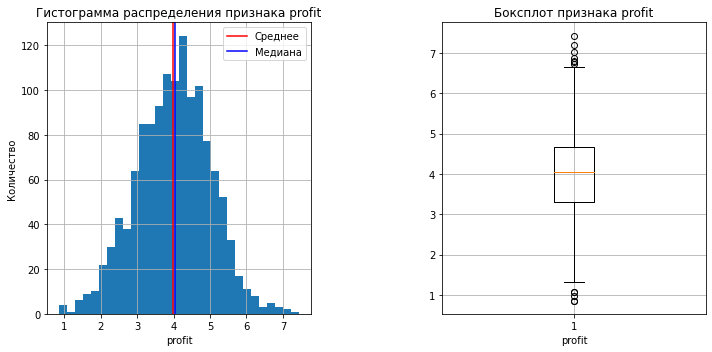

In [40]:
plot_graph(df_money['profit'])

Данные прибыли распределены нормально, фиксируем выбросы.

### Формирование датасета модели

Для прогноза покупательской активности на период три месяца используем данные клиентов, которые были активны последние три месяца. Иными словами определим пользователей датасета *df_market_money*, которые не покупали в один/несколько периодов и исключим их.

In [41]:
df_market_money.query('revenue == 0')

,id,period,revenue
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [42]:
null_clients = set(df_market_money.query('revenue == 0')['id'])

Таких пользователей оказалось всего 3. Теперь объеденим интересующие нас датасеты в один, который будем использовать для построение модели.


<div class="alert alert-success"> 
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Согласен
</div>  




In [43]:
# проверим количество уникальных клиентов во всех датасетах
for df in data_frames:
    print(df['id'].nunique())

1300
1300
1300
1300


Все датасеты содержат признаки для одинакового числа клиентов.

In [44]:
df_market_money['id'][~df_market_money['id'].isin(df_market_time['id'])].shape

(0,)

In [45]:
df_market_money['id'][~df_market_money['id'].isin(df_market_file['id'])].shape

(0,)

Эти клиенты одинаковы в таблицах, которые будем объединять. Для этого преобразуем две из них, которые содержат разные периоды для каждого клиента. Вынесем эти периоды в отдельные столбцы и переименуем их.

In [46]:
df_market_money = df_market_money.pivot_table(index='id', columns='period', values='revenue')
df_market_money.columns = [
    'revenue_previous_m',
    'revenue_before_previous_m',
    'revenue_current_m'
]

In [47]:
df_market_time = df_market_time.pivot_table(index='id', columns='period', values='minutes')
df_market_time.columns = [
    'time_previous_m',
    'time_current_m'
]


<div class="alert alert-success"> 
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично по сводным.
</div>  




In [48]:
# зададим id в качестве индексов, чтобы по ним соединять таблицы
df_market_file = df_market_file.set_index('id')

In [49]:
# объединим таблицы в одну
df_model = df_market_file.join(df_market_money, how='inner')
df_model = df_model.join(df_market_time, how='inner')

In [50]:
df_model.head(2)

,cons_activity,service_type,offers_allow,avg_marketing_activity_6_m,avg_marketing_activity_cur_m,days_registered,promo_purchase_rate,favorite_category,categories_viewed_per_visit,unpaid_items_last_3_m,service_error,pages_per_visit_last_3_m,revenue_previous_m,revenue_before_previous_m,revenue_current_m,time_previous_m,time_current_m
id,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10


Теперь удалим неинтересующих нас клиентов.

In [51]:
before = df_model.shape[0]
df_model = df_model.loc[~df_model.index.isin(null_clients)]
after = df_model.shape[0]
print(f'Было исключено {before - after} клиента.')

Было исключено 3 клиента.


Как мы определили ранее 3 клиента, ничего не покупающих в один/несколько периодов. Финальная таблица готова, и теперь можно провести корреляционный анализ и установить связи между целевым и входными признаками.

Выполним последнюю проверку на соответствие данных условию, что клиенты имели покупательную активность на протяжении как минимум 3 месяцев. Для этого их аккаунты должны быть старше 92 дней.

In [52]:
len(df_model[df_model['days_registered'] < 92])

0

### Корреляционный анализ данных

Оценим корреляцию сразу всех признаков, для этого используем подход Phik.


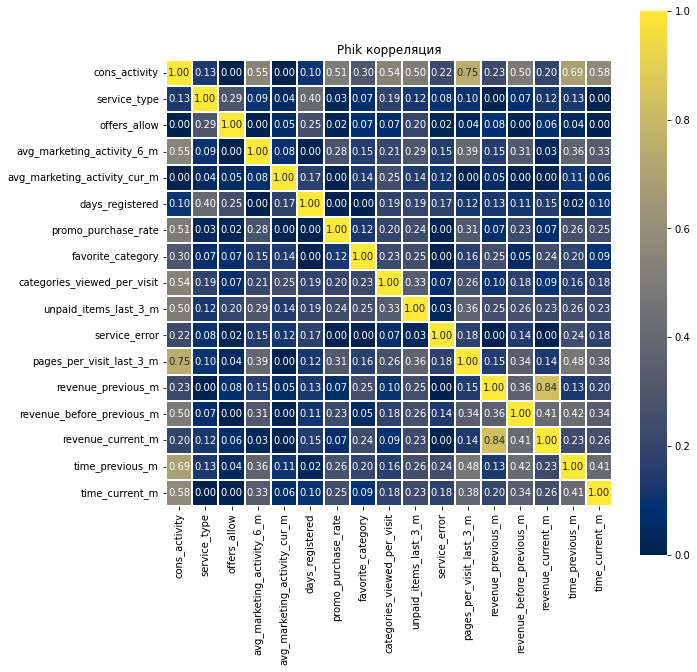

In [53]:
# визуализация коэффициентов корреляции
figsize = (10, 10)
fig = plt.subplots(figsize=figsize)
plt.title('Phik корреляция')
sns.heatmap(df_model
            .phik_matrix(interval_cols=df_model.select_dtypes(exclude='object')), 
            annot=True, cmap='cividis', 
            linewidth=0.1,
            fmt='.2f',
            square=True)
plt.show()

**Вывод:**

В данном разделе мы установили, что все количественные данные нормально распределены, некоторые признаки имеют выбросы. Это стоит учесть при построении модели: необходимо задействовать настройки для повышения устойчивости к выбросам.

Целевой признак дисбалансирован, а значит при подготовки данных, нужно стратифицировать выборку. Также целевой признак - категориальный, бинарный. Для бинарной классификации с несбалансированной выборкой хорошо подойдет метрика ROC-AUC.  
Мы объединили три датасета в один, на котором будем обучать модель. 

Корреляционный анализ показал, что с целевым признаком `cons_activity` выше всего коррелирует `pages_per_visit_last_3_m`, но недостаточно высоко (0.75), чтобы фиксировать мультиколлинеарность. 
Отметим, что высоко коррелируют между собой входные признаки `revenue_current_m` и `revenue_previous_m` (0.84).


<div class="alert alert-success"> 
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Все верно. Мультиколлинеарности нет. ROC_AUC подойдет. Правда, дисбаласн у нас здесь минимальный, подошли бы и F1 c accuracy. 
    

</div>  




<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Исследовательский анализ мы делаем для того, чтобы понять, какие закономерности заложены в наших данных. Здесь крайне важно посмотреть на распределения признаков в разрезе целевого признака (снижения активности). 
    
Можно построить и наложить друг на друга гистограммы по данным в подвыборках с и без снижения активности. Можно расположить рядом два боксплота, для категориальных данных − две диаграммы.
    
Самое банальное и простое: сгруппировать по признаку снижения активности и вывести среднее значение для каждого из признаков. Проанализировать, в каких признаках самые большие различия.
    
Важно в выводе к исследовательскому анализу дать портрет клиента, снижающего активность: какие признаки говорят о высокой вероятности ухода клиента?
    
    
В этом проекте аналитическая составляющая достаточно серьезная. Если делаем анализ данных не только для подготовки признаков для моделей, но и для того, чтобы узнать новую информацию о бизнес-процессах, то исследование в разрезе целевого признака − решение по умолчанию.
       
</div> 
 

<div class="alert alert-info">
<h2> Комментарий студента <a class="tocSkip"> </h2>
    
Добавил ниже.

In [54]:
print('Соотношение категорий "Снизалась" к "Прежний уровень":',
      df_model['cons_activity'].value_counts()[1] / df_model['cons_activity'].value_counts()[0])

Соотношение категорий "Снизалась" к "Прежний уровень": 0.6172069825436409


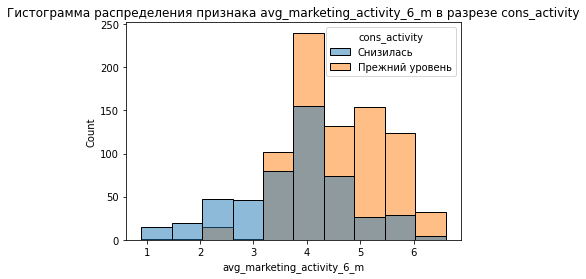

Среднее значение у группы "Снизилась": 3.7430303030303023
Среднее значение у группы "Прежний уровень": 4.570074812967581


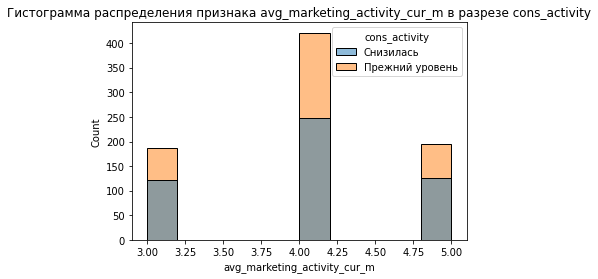

Среднее значение у группы "Снизилась": 4.006060606060606
Среднее значение у группы "Прежний уровень": 4.011221945137157


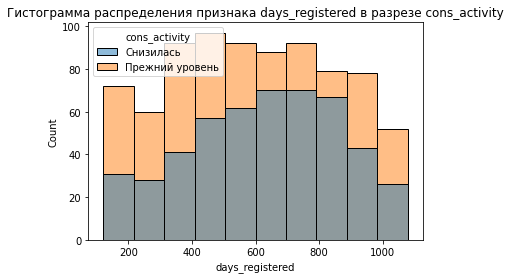

Среднее значение у группы "Снизилась": 622.8626262626262
Среднее значение у группы "Прежний уровень": 590.7306733167082


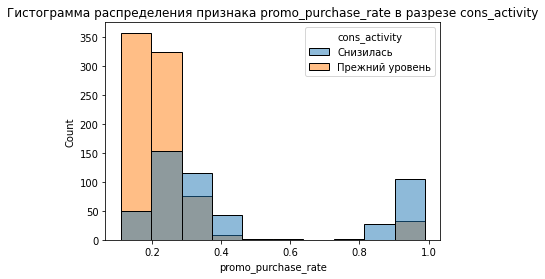

Среднее значение у группы "Снизилась": 0.4536969696969697
Среднее значение у группы "Прежний уровень": 0.23836658354114715


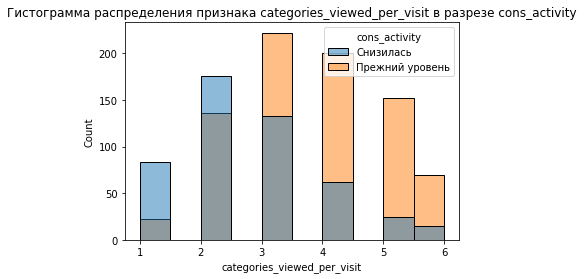

Среднее значение у группы "Снизилась": 2.6222222222222222
Среднее значение у группы "Прежний уровень": 3.665835411471322


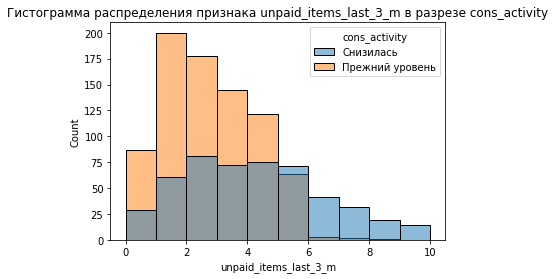

Среднее значение у группы "Снизилась": 3.7292929292929293
Среднее значение у группы "Прежний уровень": 2.2930174563591024


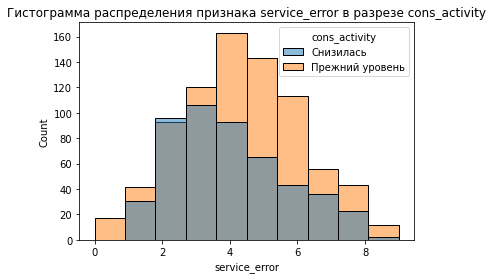

Среднее значение у группы "Снизилась": 3.9393939393939394
Среднее значение у группы "Прежний уровень": 4.335411471321696


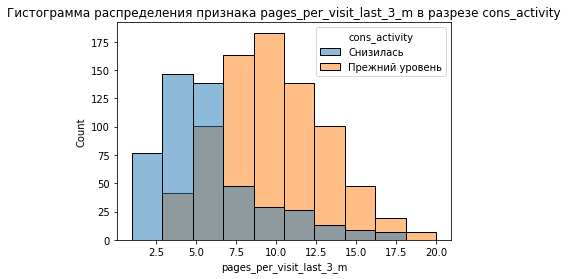

Среднее значение у группы "Снизилась": 5.5777777777777775
Среднее значение у группы "Прежний уровень": 9.796758104738155


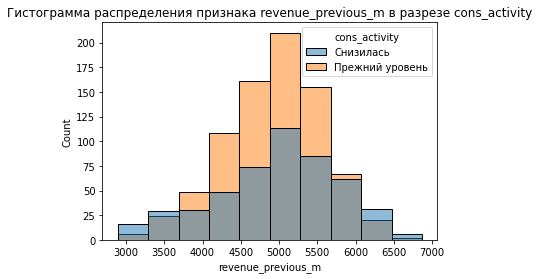

Среднее значение у группы "Снизилась": 4973.9070707070705
Среднее значение у группы "Прежний уровень": 4932.559226932668


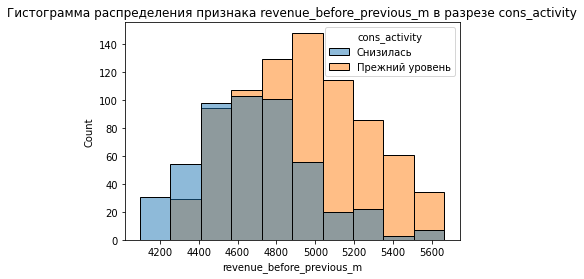

Среднее значение у группы "Снизилась": 4679.034343434343
Среднее значение у группы "Прежний уровень": 4933.47506234414


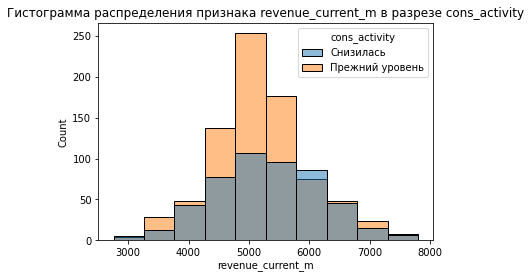

Среднее значение у группы "Снизилась": 5302.972323232323
Среднее значение у группы "Прежний уровень": 5197.704114713217


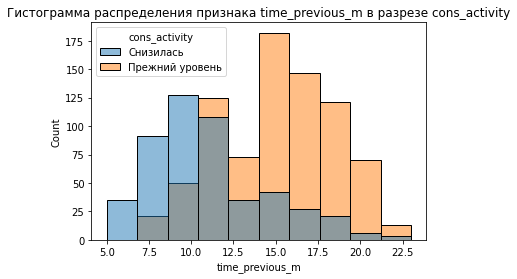

Среднее значение у группы "Снизилась": 10.94141414141414
Среднее значение у группы "Прежний уровень": 15.029925187032418


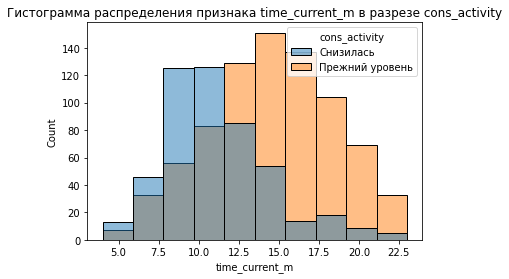

Среднее значение у группы "Снизилась": 10.953535353535354
Среднее значение у группы "Прежний уровень": 14.604738154613466


In [55]:
for column in df_model.select_dtypes(exclude='object').columns:
    
    sns.histplot(data=df_model, x=column, hue='cons_activity', bins=10)
    plt.title(f'Гистограмма распределения признака {column} в разрезе cons_activity')
    plt.show()
    
    print(f'Среднее значение у группы "Снизилась":', df_model
                                                        .query('cons_activity == "Снизилась"')[column]
                                                        .mean())
    print(f'Среднее значение у группы "Прежний уровень":', df_model
                                                        .query('cons_activity == "Прежний уровень"')[column]
                                                        .mean())

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 По визуализации все отлично.
</div>


При рассмотрении количественных признаков в разрезе целевого выявили следующие особенности:
+ `avg_marketing_activity_6_m`: у группы, не изменившей активность, распределение смещено в сторону большего числа маркетинговых взаимодействий за последние полгода;
+ `avg_marketing_activity_cur_m`: распределения похожие;
+ `days_registered`: в среднем у группы со сниженной активностью аккаунты старше;
+ `promo_purchase_rate`: намного больше покупок в промо акциях совершили клиенты из группы, снизившей активность;
+ `categories_viewed_per_visit`: покупатели, не изменившие активность, больше просматривают категорий;
+ `days_registered`: покупатели, не изменившие активность, практически не оставляют неоплаченными более 6 товаров, тогда, как у другой группы этот показатель заметно выше;
+ `service_error`: количество ошибок у группы с понижением меньше, чем меньше времени проводить на сайте, тем выше вероятность избежать ошибок работы сервиса или, возможно, ошибки заставляли данных клиентов не пользоваться сервисом дольше;
+ `pages_per_visit_last_3_m`: такой же скос в сторону меньшего количество страниц у этой же группы клиентов;
+ `revenue`: по тратам лидер трат чередуется каждый месяц, но в самый дальний период траты группы с пониженной активностью были заметно выше, возможно, произошла покупка по промо акциям в этот период.
+ `time`: группа с неизменившейся автивностью в любой период в среднем проводит на сервисе на 5 минут дольше.


<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Ок. Здесь можно прямо перечислить, по каким признакам больше всего различий в подвыборках?
</div>


Для категориальных столбцов тоже построим диаграмму в процентном выражении.

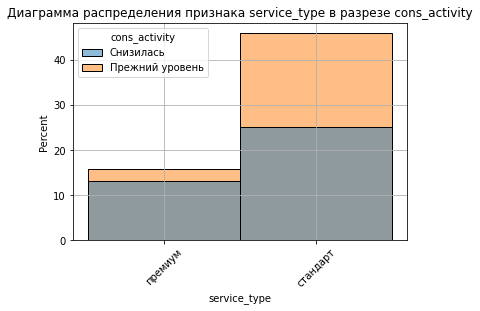

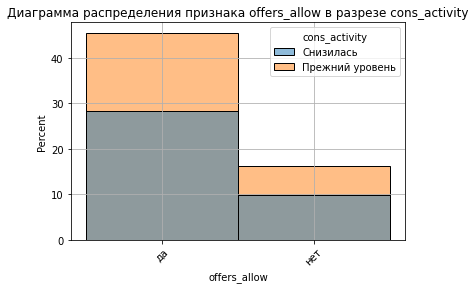

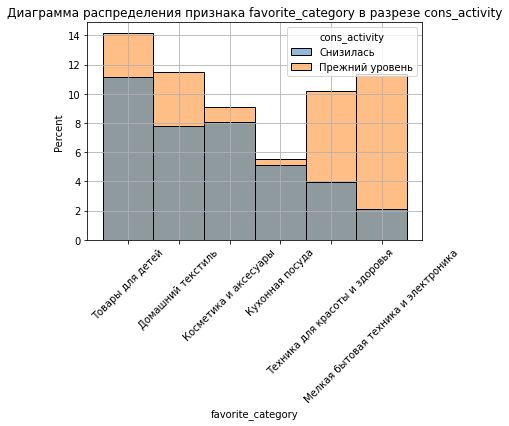

In [56]:
for column in df_model.select_dtypes(include='object').drop('cons_activity', axis=1).columns:
 
    
    sns.histplot(data=df_model, x=column, hue='cons_activity', stat='percent')
    plt.title(f'Диаграмма распределения признака {column} в разрезе cons_activity')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

Из категориальных данных делаем следующие выводы:
+ почти половина клиентов премиум сервиса понизили свою покупательную активность;
+ разделение клиентов, которые отказались от рассылок, происходит почти в равных пропорциях;
+ клиенты, покупающие товары из категорий *Техника для красоты и здоровья* и *Мелкая бытовая техника и электроника* меньше снижают активность чем покупатели других категорий.

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Здесь верно.
</div>


**Дополнение к выводу:**

Рассмотрев входные признаки в разрезе целового, мы видим характерные признаки, присущие для падения активности: 
+ пользование премиум сервисом;
+ уменьшение маркетингового взаимодействия и времени взаимодействия с сервисом;
+ заметным маркером является покупка промо товаров, что ведет к увеличению трат в период за несколько месяцев до начала прогноза. Причем покупки у данных клиентов совершены в категориях *Товары для детей*, *Домашний текстиль*, *Косметика и аксессуары*, *Кухонная посуда*.   

Маржинальность этих товаров выше чем сложной техники, скорее всего эти клиенты будут в числе, принесших большую прибыль магазину. Поэтому очень важно разработать меры по удержанию активности данной группы клиентов.


<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Отлично.
</div>


## Построение модели

Разделим выборку на тренировочную и тестовую и закодируем целевой признак для корректного использования в метрике. 

In [57]:
RANDOM_STATE = 13
TEST_SIZE = 0.25

# разделяем данные на входные признаки и целевой
X = df_model.drop('cons_activity', axis=1)
y = df_model['cons_activity']

# кодируем целевой признак
label_encoder = LabelEncoder()
y_labeled = label_encoder.fit_transform(y)

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_labeled, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_labeled
)

In [58]:
# разделим столбцы на количественные и категориальные
ohe_columns = df_model.select_dtypes(include='object').drop('cons_activity', axis=1).columns.tolist()
num_columns = df_model.select_dtypes(exclude='object').columns.tolist()

В данных пропусков нет, но так может быть не всегда, поэтому в пайплайн добавим возможность заполнять пропуски с помощью *SimpleImputer*. Порядковых данных таблица не содержит, поэтому сделаем только ohe-кодирование для категориальных данных.

In [59]:
# пайплайн для подготовки категориальных признаков
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
        ),
        (
            'ohe',
             OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [60]:
# общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [61]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [62]:
# разные модели с разными гиперпараметрами
param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            penalty='elasticnet', 
            solver='saga'
        )
                  ],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ],
        'models__l1_ratio': np.linspace(0.1, 1, num=10)
        
    },
    
    {
        'models': [KNeighborsClassifier()],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ],
        'models__metric': ['euclidean', 'minkowski', 'cityblock'],
        'models__n_neighbors': range(1, 15),
        
    },
    
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly']
    },
    
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'models__min_samples_split': range(2, 5),
        'preprocessor__num': [StandardScaler(), 
                              MinMaxScaler(), 
                              RobustScaler(), 
                              'passthrough'
                             ]
    }
]

In [63]:
# перебор всех моделей и гиперпараметров
search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    cv=5, 
    scoring='roc_auc',  
    n_jobs = -1,
    random_state=RANDOM_STATE
)
    
search.fit(X_train, y_train) 
print('Лучшая модель и её параметры:\n\n', search.best_estimator_)
print('Метрика ROC-AUC для лучшей модели:\n', search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['service_type',
                                                   'offers_allow',
                                                   'favorite_category']),
                                

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 Отлично, что используешь `remainder='passthrough'` . Хороший выбор гиперпараметров и значений для подбора. Отлично, что пробуем два типа масштабирования.
</div> 


In [64]:
best_model = search.best_estimator_.named_steps['models']
preprocessor = search.best_estimator_['preprocessor']
X_train_preprocessored = preprocessor.transform(X_train)
X_test_preprocessored = preprocessor.transform(X_test)

In [65]:
best_model.fit(X_train_preprocessored, y_train)
preds = best_model.predict_proba(X_test_preprocessored)
roc_auc = roc_auc_score(y_test, preds[:,1])
print('ROC-AUC =', roc_auc.round(4))

ROC-AUC = 0.8989


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Здесь я бы не округлял до двух знаков после запятой (хотя бы три уже было бы информативнее)

### Анализ важности признаков

Для интерпретации модели и оценки важности входных признаков воспользуемся методом SHAP. Подготовим данные, чтобы отображались название признаков.

In [66]:
features_name = (list(preprocessor['ohe'].get_feature_names_out()) +
                 list(preprocessor['num'].get_feature_names_out())
    
)

X = pd.DataFrame(X_train_preprocessored, columns=features_name)

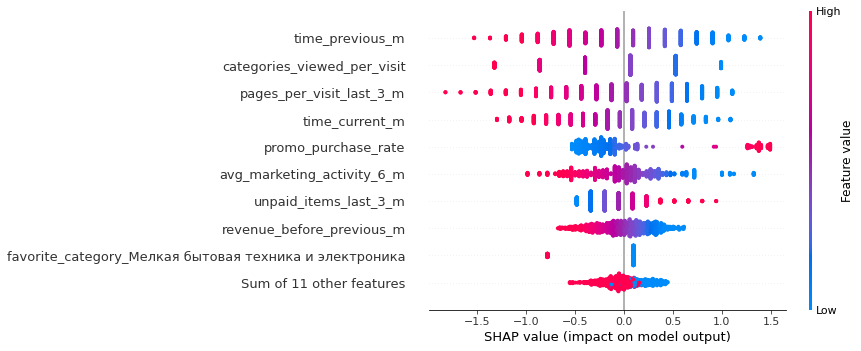

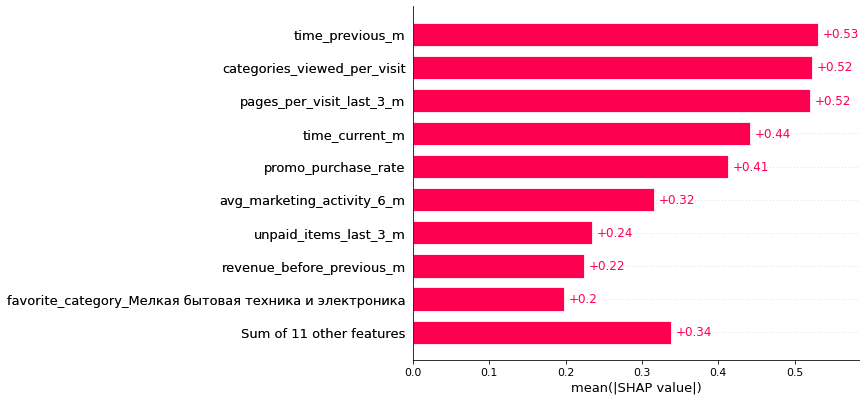

In [67]:
explainer = shap.LinearExplainer(best_model, X)
shap_values = explainer(X)

shap.plots.beeswarm(shap_values) 
shap.plots.bar(shap_values)

Перед тем как интерпретировать графики и влияние входных признаков на прогноз целевого вспомним, что LabelEncoder кодирует за 1 то, что встречает впервые, а это было категория "снизилась".Таким образом положительные shap-значения будут нам говорить о склонении модели классифицировать как "снизилась", отрицательные - "не изменилась".

Из столбчатой диаграммы мы видим названия всех признаков, которые важны в этой классификации. 11 остальных вместе взятых сопоставимы по весу с одним из представленных признаков.

Более подробно рассмотрим топ признаков:
+ `time_previous_m`, `categories_viewed_per_visit`, `pages_per_visit_last_3_m`, `time_current_m`, `avg_marketing_activity_6_m`, `revenue_before_previous_m` высокие значения этих признаков склоняют модель прогнозировать активность пользователей как "не изменилась", низкие наоборот - "снизилась".
+ `promo_purchase_rate`, `unpaid_items_last_3_m` напротив, высокими значениями склоняют модель к категории "снизилась", а низкими - "не изменилась".


Остальные признаки можно считать малозначимыми для модели.

Можно объединить столбцы, описывающие время проведенное на сайте, просмотренные категории, посещенные страницы как маркер заинтересованности клиентов. В модели эти столбцы занимают первые четыре места по значимости. В исследовательском анализе мы также отмечали, что клиенты, имеющие более высокие значения в этих столбцах, не изменили активность. Что выглядит достаточно логичным - высокий уровень заинтересованности отражает уровень покупательской активности. И, напротив, покупатели, отдающие предпочтения покупкам в промо акциях имеют некоторую сезонность. Несмотря на высокую маржинальность таких клиентов, постоянного интереса к покупкам они не испытывают, ожидая периода акционных распродаж, об этом говорит их корзина с большим количеством неоплаченных товаров, возможно, ожидающая подходящего периода. Также схожим с анализом ранее является категория "Мелкая бытовая техника и электроника", которую покупают больше клиенты с постоянной активностью. 

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

👍 ОК по описательной аналитике. Здесь же можно попробовать дать первые гипотезы и объяснения. Например, почему те, кто все покупает по акции, снижают активность?
    
Также можно будет сопоставить значимость признаков с нашими выводами по исследовательскому анализу (портрету клиента со снижением активности).

## Сегментация покупателей

Сформируем список наиболее значимых по влиянию на прогноз активности признаков. 

In [68]:
important_cols = ['time_previous_m', 
                  'categories_viewed_per_visit', 
                  'pages_per_visit_last_3_m',
                  'time_current_m', 
                  'avg_marketing_activity_6_m',
                  'revenue_before_previous_m',
                  'promo_purchase_rate',
                  'unpaid_items_last_3_m']

Добавим в таблицу столбец с информацией о прибыльности клиентов магазина.

In [69]:
df_money = df_money.set_index('id')
df_segmentation = df_model.join(df_money, how='inner')

### Сегментация по прибыльности клиентов

Выделим сегмент наиболее ценных покупателей, т.е. тех, кто приносит магазину самую высокую прибыль. Возьмем 10% самых прибыльных клиентов.

In [70]:
most_profitable_seg = df_segmentation[df_segmentation['profit'] >= df_segmentation['profit']
                                      .quantile(0.9)]
most_profitable_seg.shape

(135, 18)

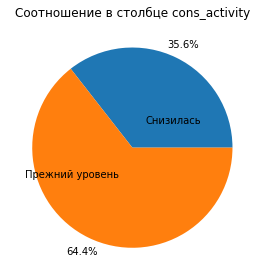

In [71]:
make_pie_plot(most_profitable_seg, 'cons_activity')

Для 64.4% из этого сегмента клиентов ожидается, что они не снизят активность. Отметим, что тенденция на снижение меньше на 3% чем в среднем по всей таблице. Рассмотрим каждую категорию отдельно. Для этого разделим сегмент по покупательской активности, нормализуем и по средним значениям построим сравнительную столбчатую диаграмму. Как базовую выборку включим средние всей таблицы. 

In [72]:
most_profitable_seg_decreased = (most_profitable_seg
                                    .query('cons_activity == "Снизилась"')[important_cols])

most_profitable_seg_stable = (most_profitable_seg
                              .query('cons_activity == "Прежний уровень"')[important_cols])

base_seg_decreased = (df_segmentation
                                    .query('cons_activity == "Снизилась"')[important_cols])

base_seg_stable = (df_segmentation
                              .query('cons_activity == "Прежний уровень"')[important_cols])


In [73]:
# проводим нормализацию и 
# вычисляем средние
scaler = MinMaxScaler()

most_profitable_seg_decreased = scaler.fit_transform(most_profitable_seg
                                        .query('cons_activity == "Снизилась"')[important_cols]
                                       ).mean(axis=0)
most_profitable_seg_stable = scaler.transform(most_profitable_seg
                                    .query('cons_activity == "Прежний уровень"')[important_cols]
                                    ).mean(axis=0)

base_seg_decreased = scaler.fit_transform(df_segmentation
                                        .query('cons_activity == "Снизилась"')[important_cols]
                                       ).mean(axis=0)

base_seg_stable = scaler.transform(df_segmentation
                                    .query('cons_activity == "Прежний уровень"')[important_cols]
                                    ).mean(axis=0)

In [74]:
# обернем все в датафрейм
comparison_plot = pd.DataFrame(
    {
        'profitable_clients_decreased': most_profitable_seg_decreased,
        'profitable_clients_stable': most_profitable_seg_stable,
        'avg_clients_decreased': base_seg_decreased,
        'avg_clients_stable': base_seg_stable
    }, index=important_cols
)

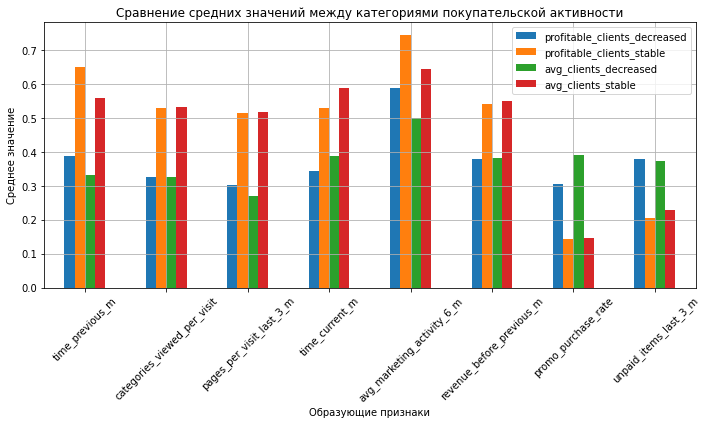

In [75]:
# строим диаграмму
comparison_plot.plot(kind='bar', figsize=(10, 6))

# заголовки и подписи
plt.title('Сравнение средних значений между категориями покупательской активности')
plt.ylabel('Среднее значение')
plt.xlabel('Образующие признаки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()

plt.show()

Напомним, что доля снижения активности для сегмента наиболее выгодных клиентов для магазины немного ниже чем в среднем для всех клиентов. 
+ `time_previous_m`: показатели выгодных клиентов выше средних клиентов.
+ `categories_viewed_per_visit`: здесь абсолютно схожий показатель у этих сегментов.
+ `pages_per_visit_last_3_m`: в этом признаке показатели выше у сегмента наиболее выгодных клиентов.
+ `time_current_m`: а вот в этом признаке мы видим, что средняя выборка по всем клиентам имеет более высокие значения, что указывает на одно из предложений по увеличению активности сегмента - увеличить интерес клиентов.
+ `avg_marketing_activity_6_m`: по маркетинговой активности тоже превосходство сегмента над средними показателями.
+ `revenue_before_previous_m`: в среднем клиенты, у которых активность не изменилась, тратили немного больше, чем самые прибыльные. Значит, необходимо поддерживать уровень трат еще за 4 месяца до прогнозного периода.
+ `promo_purchase_rate`: здесь видим, что средние клиенты тратят даже больше, значит большая прибыльность не сильно связана с промо товарами.
+ `unpaid_items_last_3_m`: здесь показатели схожие.

В целом по поведению клиенты, приносящие наибольшую выгоду магазину, похожи на среднего клиента, немного больше имеют заинтересованность в сервисе, что делает их более постоянными покупателями, поэтому доля снижения здесь немного ниже чем по всей выборке.

Еще раз взглянем на покупки промо для сегмента самых выгодных клиентов и средних.

In [76]:
print('Среднее значение коэффициента промо покупок сегмента выгодных клиентов:', most_profitable_seg['promo_purchase_rate'].mean())
print('Среднее значение коэффициента промо покупок сегмента общего числа клиентов:', df_segmentation['promo_purchase_rate'].mean())

Среднее значение коэффициента промо покупок сегмента выгодных клиентов: 0.29451851851851857
Среднее значение коэффициента промо покупок сегмента общего числа клиентов: 0.32054741711642254


Промо покупки у выгодных клиентов ниже, значит прибыльность магазина не в первую очередь определена промо активностью. Посмотрим какие товары приобретали самые выгодные клиенты.

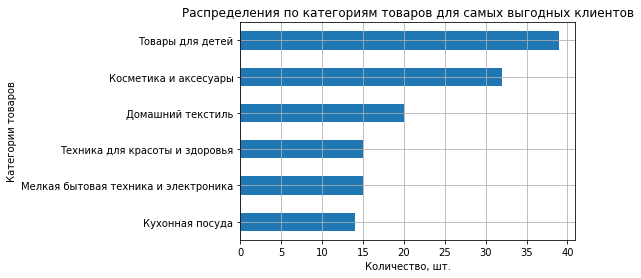

In [77]:
most_profitable_seg['favorite_category'].value_counts(ascending=True).plot(kind='barh', grid=True)
plt.title('Распределения по категориям товаров для самых выгодных клиентов')
plt.xlabel('Количество, шт.')
plt.ylabel('Категории товаров')
plt.show()

Лидирующие категории - самые маржинальные среди товаров, этим объясняется высокая прибыльность для магазина.

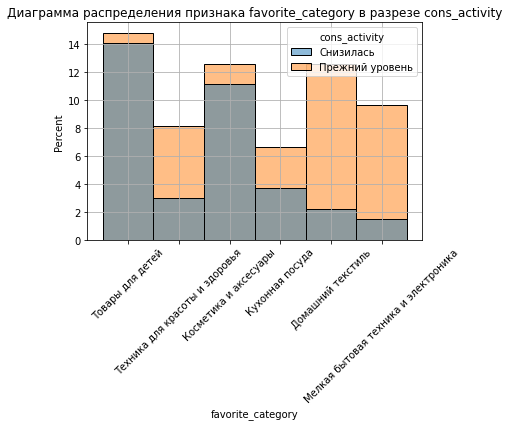

In [78]:
sns.histplot(data=most_profitable_seg, x='favorite_category', hue='cons_activity', stat='percent')
plt.title(f'Диаграмма распределения признака {column} в разрезе cons_activity')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Выделим тройку товаров, которая есть у стабильных клиентов и намного меньше покупают клиенты, снизившие активность: "Мелкая бытовая техника и электроника"(самое больший вес среди товаров согласно модели), "Домашний текстиль", "Техника для красоты и здоровья".

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Ага. Вполне возможно, на эти категории была акция, а когда акция завершилась, то группа клиентов, привлеченная этой акцией, начала снижать активность.
</div>


In [79]:
print('Согласие на маркетинговое взаимодействие:')
display(most_profitable_seg['offers_allow'].value_counts())
print('Среднее число маркетинговых активностей из числа выгодных клиентов:', 
      most_profitable_seg['avg_marketing_activity_6_m'].mean())
print('Среднее число маркетинговых активностей по всей выборке:', 
      df_segmentation['avg_marketing_activity_6_m'].mean())

Согласие на маркетинговое взаимодействие:


да     94
нет    41
Name: offers_allow, dtype: int64

Среднее число маркетинговых активностей из числа выгодных клиентов: 4.453333333333334
Среднее число маркетинговых активностей по всей выборке: 4.254433307633


Открытость на маркетинговое взаимодействие выбранного сегмента открывает возможность отрегулировать категории товаров потребления, сместив акцент на ту группу товаров, которую мы выделили выше.

<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 

Количество времени, проводимое на сайте − это просто индикатор заинтересованности в покупках, но не причина активности в покупках. Примерно как значок недостатка топлива в баке не является причиной остановки автомобиля, хотя и коррелирует с фактом остановки. 
    

****
    
Это как в магазине количество покупок будет очень сильно коррелировать с числом зашедших покупателей и средним временем, которое покупатель проводит в магазине. Но просить покупателей зайти и выйти по три раза или подольше не уходить из магазина, чтобы увеличить формальное количество заходов в магазин или длительность нахождения точно не стоит, на покупки это не повлияет.
       
       
</div> 


Еще одной интересной с точки зрения поддержки магазина является сегментация по типу сервиса.

### Сегментация по типу сервиса

In [80]:
premium_seg = df_segmentation.loc[df_segmentation['service_type'] == 'премиум']
standart_seg = df_segmentation.loc[df_segmentation['service_type'] == 'стандарт']

Отношение для премиум сегмента


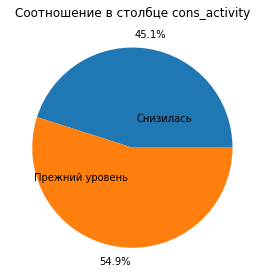

Отношение для стандарт сегмента


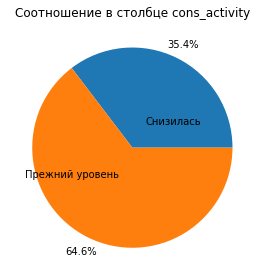

In [81]:
print('Отношение для премиум сегмента')
make_pie_plot(premium_seg, 'cons_activity')
print('Отношение для стандарт сегмента')
make_pie_plot(standart_seg, 'cons_activity')

Отметим, что клиенты премиум сервиса на 10% имеет больший шанс снизить активность. 

In [82]:
# проводим нормализацию и 
# вычисляем средние
scaler = MinMaxScaler()

premium_seg_decreased = scaler.fit_transform(premium_seg
                                        .query('cons_activity == "Снизилась"')[important_cols]
                                       ).mean(axis=0)
premium_seg_stable = scaler.transform(premium_seg
                                    .query('cons_activity == "Прежний уровень"')[important_cols]
                                    ).mean(axis=0)

standart_seg_decreased = scaler.fit_transform(standart_seg
                                        .query('cons_activity == "Снизилась"')[important_cols]
                                       ).mean(axis=0)

standart_seg_stable = scaler.transform(standart_seg
                                    .query('cons_activity == "Прежний уровень"')[important_cols]
                                    ).mean(axis=0)

In [83]:
# обернем все в датафрейм
comparison_plot = pd.DataFrame(
    {
        'premium_clients_decreased': premium_seg_decreased,
        'premium_clients_stable': premium_seg_stable,
        'standart_clients_decreased': standart_seg_decreased,
        'standart_clients_stable': standart_seg_stable
    }, index=important_cols
)

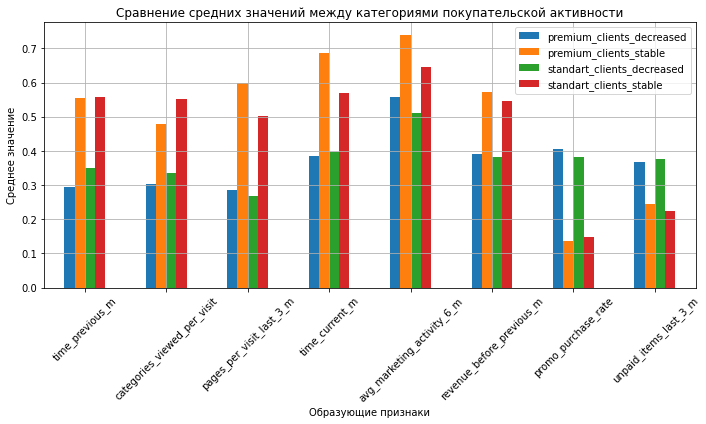

In [84]:
# строим диаграмму
comparison_plot.plot(kind='bar', figsize=(10, 6))

# заголовки и подписи
plt.title('Сравнение средних значений между категориями покупательской активности')
plt.ylabel('Среднее значение')
plt.xlabel('Образующие признаки')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()

plt.show()

Чтобы понять, что дает преимущество клиентам стандарт сервиса, нужно сравнить средние значения с клиентами премиум сервиса, найти признаки с разницей в этих показателях.
+ `time_previous_m`: времени оба сегмента проводят почти одинаково, даже премиум клиенты с понижением активности проводят меньше чем аналогичный срез стандарта.
+ `categories_viewed_per_visit`: здесь тоже преимущество клиентов стандарта.
+ `pages_per_visit_last_3_m`: а здесь мы фиксируем, что премиум пользователи просматривают немного больше страниц за каждый визит. Возможно специальные предложения побуждают больше выбирать.
+ `time_current_m`: снова премиум клиенты превосходят клиентов стандарта. Это говорит о том, что важно удерживать постоянно внимание клиентов и побуждать проводить больше времени.
+ `avg_marketing_activity_6_m`: большее маркетинговое взаимодействие премиум клиентов это преимущество в увеличении активности.
+ `revenue_before_previous_m`:траты премиум клиентов тоже немного выше.
+ `promo_purchase_rate`: фиксируем схожее поведение - тот, кто потратил много на промоакциях, снижает свою активность независимо от сервиса.
+ `unpaid_items_last_3_m`: схожее влияние неоплаченных покупок.

В целом по графику, отметим немного более высокую заинтересованность клиентов стандарта, связанного с большим количеством проведенного времени, просмотренных категорий. 

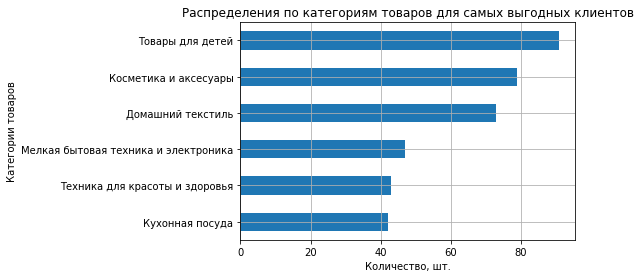

In [85]:
premium_seg['favorite_category'].value_counts(ascending=True).plot(kind='barh', grid=True)
plt.title('Распределения по категориям товаров для самых выгодных клиентов')
plt.xlabel('Количество, шт.')
plt.ylabel('Категории товаров')
plt.show()

В топ-3 популярных категориях наблюдаем самые маржинальные товары.

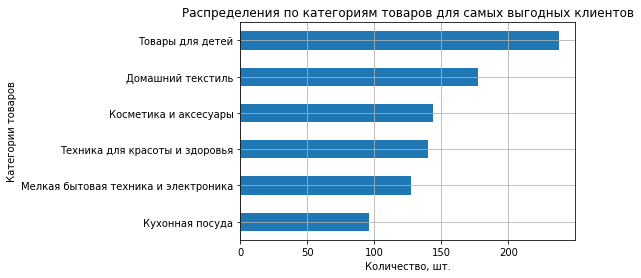

In [86]:
standart_seg['favorite_category'].value_counts(ascending=True).plot(kind='barh', grid=True)
plt.title('Распределения по категориям товаров для самых выгодных клиентов')
plt.xlabel('Количество, шт.')
plt.ylabel('Категории товаров')
plt.show()

Точно такой же топ-3 по составу категорий для всей выборки.

Вспомним распределение промо покупок.

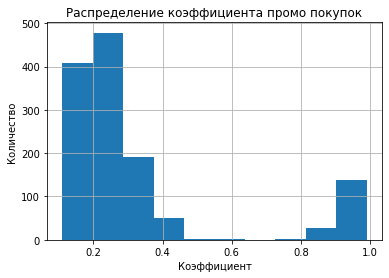

In [87]:
df_segmentation['promo_purchase_rate'].hist()
plt.title('Распределение коэффициента промо покупок')
plt.ylabel('Количество')
plt.xlabel('Коэффициент')
plt.grid(True)
plt.show()

В распределении видим два кластера, первый - клиенты, приобретающие больше обычных товаров, второй - преимущественно по акциям. Можно выделить новый сегмент - покупатели с промо коэффициентом более 0.5

In [88]:
promo_seg = df_segmentation[df_segmentation['promo_purchase_rate'] > 0.5]
len(promo_seg)

168

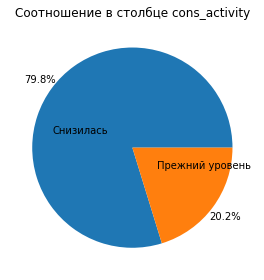

In [89]:
make_pie_plot(promo_seg, 'cons_activity')

Удачно выбрали сегмент с почти четырехкрантным преобладанием понижения активности.

In [90]:
promo_seg.pivot_table(index='cons_activity')

,avg_marketing_activity_6_m,avg_marketing_activity_cur_m,categories_viewed_per_visit,days_registered,pages_per_visit_last_3_m,profit,promo_purchase_rate,revenue_before_previous_m,revenue_current_m,revenue_previous_m,service_error,time_current_m,time_previous_m,unpaid_items_last_3_m
cons_activity,,,,,,,,,,,,,,
Прежний уровень,4.361765,4.029412,3.500000,559.088235,9.588235,3.925588,0.938529,4949.235294,5222.405882,4889.529412,4.411765,14.764706,15.294118,2.117647
Снизилась,3.620149,3.962687,2.641791,614.097015,4.753731,3.854104,0.941194,4652.402985,5253.383582,4953.492537,4.059701,10.582090,10.410448,3.992537


Изучим разницу между категориями активности, чтобы понять, что позволило клиентам ее сохранить.

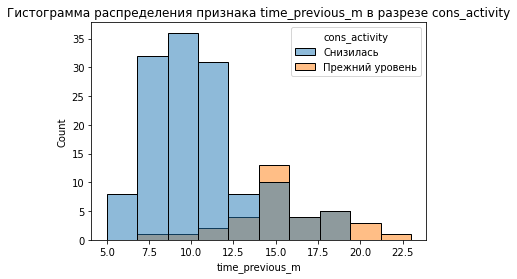

Среднее значение у группы "Снизилась": 10.41044776119403
Среднее значение у группы "Прежний уровень": 15.294117647058824


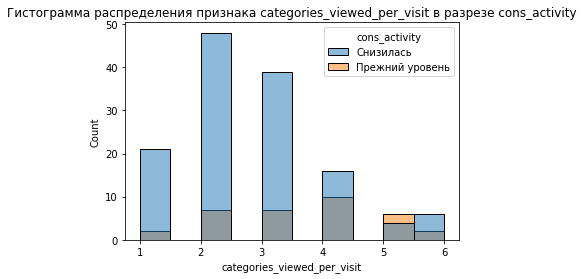

Среднее значение у группы "Снизилась": 2.6417910447761193
Среднее значение у группы "Прежний уровень": 3.5


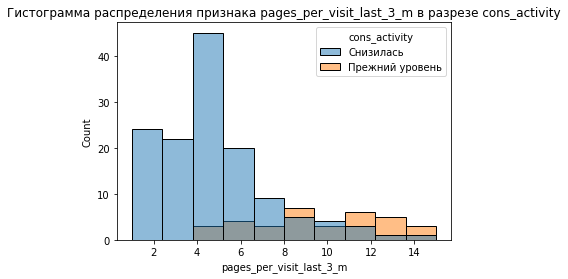

Среднее значение у группы "Снизилась": 4.753731343283582
Среднее значение у группы "Прежний уровень": 9.588235294117647


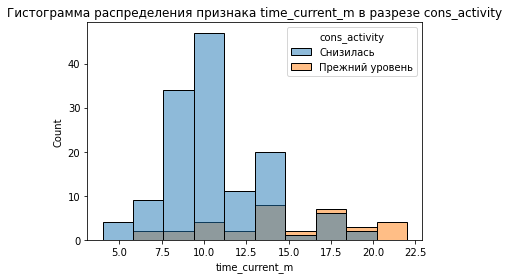

Среднее значение у группы "Снизилась": 10.582089552238806
Среднее значение у группы "Прежний уровень": 14.764705882352942


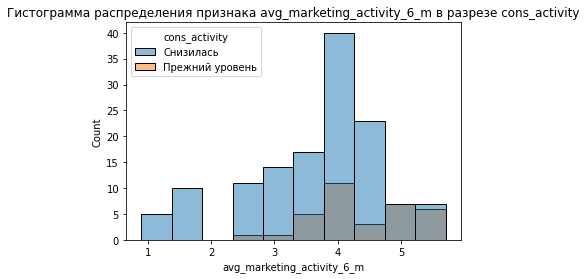

Среднее значение у группы "Снизилась": 3.620149253731343
Среднее значение у группы "Прежний уровень": 4.3617647058823525


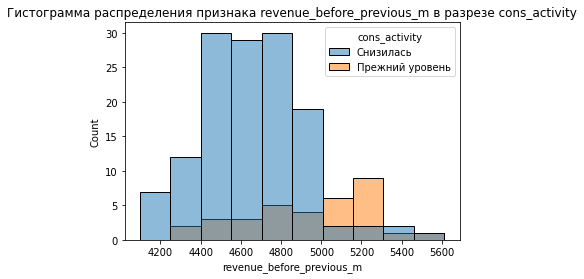

Среднее значение у группы "Снизилась": 4652.4029850746265
Среднее значение у группы "Прежний уровень": 4949.235294117647


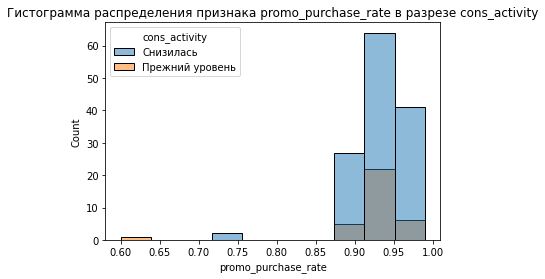

Среднее значение у группы "Снизилась": 0.9411940298507463
Среднее значение у группы "Прежний уровень": 0.9385294117647058


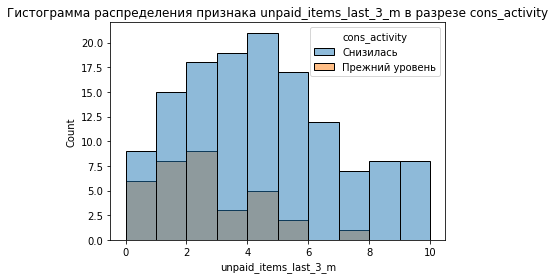

Среднее значение у группы "Снизилась": 3.9925373134328357
Среднее значение у группы "Прежний уровень": 2.1176470588235294


In [91]:
for column in important_cols:
    
    sns.histplot(data=promo_seg, x=column, hue='cons_activity', bins=10)
    plt.title(f'Гистограмма распределения признака {column} в разрезе cons_activity')
    plt.show()
    
    print(f'Среднее значение у группы "Снизилась":', promo_seg
                                                        .query('cons_activity == "Снизилась"')[column]
                                                        .mean())
    print(f'Среднее значение у группы "Прежний уровень":', promo_seg
                                                        .query('cons_activity == "Прежний уровень"')[column]
                                                        .mean())

В итоге напишем, какие признаки имеют более высокие/низкие значения у категории, сохранившей активность по сравнению с категорией, ее снизившей:
+ более высокое маркетинговое взаимодействие за последние полгода;
+ выше заинтересованность на основе признаков о времени и просмотренных категорий/страниц;
+ выше расходы за три месяца до прогноза;
+ меньше неоплаченных покупок.

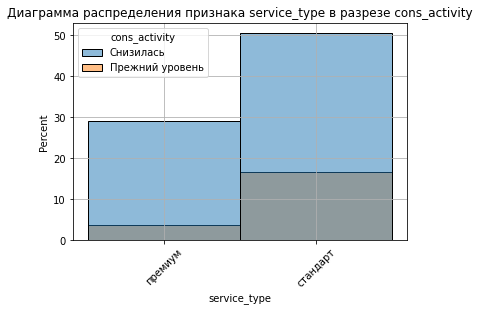

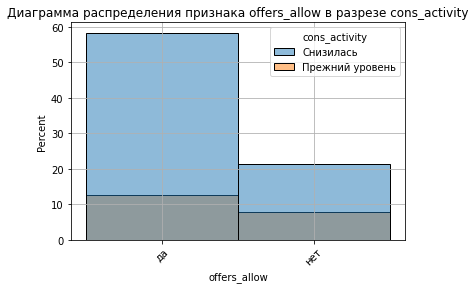

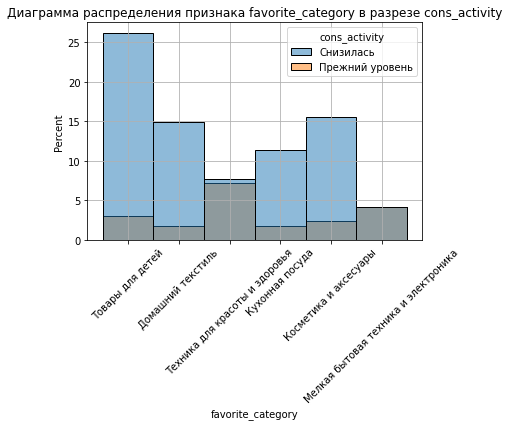

In [92]:
for column in promo_seg.select_dtypes(include='object').drop('cons_activity', axis=1).columns:
 
    sns.histplot(data=promo_seg, x=column, hue='cons_activity', stat='percent')
    plt.title(f'Диаграмма распределения признака {column} в разрезе cons_activity')
    plt.xticks(rotation=45)
    plt.grid()
    plt.show()

Характеристика группы, сохранившей активность:
+ больше присутствие в сервисе стандарт чем премиум;
+ больше присутствие среди тех, кто отказался от рассылок;
+ избранные категории: "Техника для красоты и здоровья", "Мелкая бытовая техника и электроника".

В категории с большим перевесом в сторону понижения сохранить активность удалось клиентам, которые в большинстве своем пользовались стандартным сервисом, отказались от рассылок, но тем не менее имели повышенный интерес к сервису. Имея пик трат за несколько месяцев до прогноза с популярными категориями товаров  "Техника для красоты и здоровья", "Мелкая бытовая техника и электроника".

Выжным маркером для всех сегментов становится траты задолго до прогноза и определенные категории товаров. Рассмотрим эти факторы совместно.

In [93]:
df_segmentation.pivot_table(index='favorite_category', 
                            values=['revenue_previous_m', 
                                    'revenue_before_previous_m', 
                                    'revenue_current_m',
                                    'profit'
                                   ])

,profit,revenue_before_previous_m,revenue_current_m,revenue_previous_m
favorite_category,,,,
Домашний текстиль,4.011960,4847.060000,5365.237600,5095.342000
Косметика и аксесуары,4.087623,4822.668161,5376.837220,5100.228700
Кухонная посуда,4.062609,4820.659420,5556.614493,5206.688406
Мелкая бытовая техника и электроника,3.938391,4885.155172,5287.467241,5028.281609
Техника для красоты и здоровья,3.794098,4838.803279,4984.645902,4668.590164
Товары для детей,4.042948,4816.960486,5027.852888,4738.644377


Самые значительные просадки видим за два месяца до прогнозного в категории "Техника для красоты и здоровья". Есть предположение, что это изменение связано с периодом промо акции, которую проводили для самой нерентабельной категории. Для проверки создадим таблицу для охотников за промо акциями, клиентами, с очень высоким коэффициентом `promo_rate`.

In [94]:
df_segmentation[df_segmentation['promo_purchase_rate'] > 0.95].pivot_table(index='favorite_category', 
                            values=['revenue_previous_m', 
                                    'revenue_before_previous_m', 
                                    'revenue_current_m',
                                    'profit'
                                   ])

,profit,revenue_before_previous_m,revenue_current_m,revenue_previous_m
favorite_category,,,,
Домашний текстиль,3.875556,4664.111111,5185.500000,4924.055556
Косметика и аксесуары,3.263333,4644.083333,5654.975000,5335.500000
Кухонная посуда,3.925455,4715.909091,5979.936364,5623.500000
Мелкая бытовая техника и электроника,3.865000,4476.500000,5938.550000,5180.000000
Техника для красоты и здоровья,3.285000,4728.833333,4623.016667,4075.500000
Товары для детей,4.362857,4624.285714,5396.914286,5063.928571


Здесь мы видим более существенные просадки, а т.к. в 95% случаев клиенты покупают по акции, то повышение трат в категориях объясняется созданием очередной промо акции.

In [95]:
df_segmentation[df_segmentation['promo_purchase_rate'] > 0.8] 

,cons_activity,service_type,offers_allow,avg_marketing_activity_6_m,avg_marketing_activity_cur_m,days_registered,promo_purchase_rate,favorite_category,categories_viewed_per_visit,unpaid_items_last_3_m,service_error,pages_per_visit_last_3_m,revenue_previous_m,revenue_before_previous_m,revenue_current_m,time_previous_m,time_current_m,profit
id,,,,,,,,,,,,,,,,,,
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
215364,Снизилась,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,2.67
215365,Снизилась,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6,10,3.65
215373,Снизилась,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10,8,3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216602,Прежний уровень,стандарт,нет,3.4,5,170,0.95,Техника для красоты и здоровья,4,1,3,10,5221.0,4887.0,5058.5,17,11,3.00
216604,Прежний уровень,стандарт,да,4.9,5,350,0.99,Домашний текстиль,3,4,5,5,4545.0,4735.0,4840.1,14,14,2.88
216605,Прежний уровень,стандарт,да,3.2,4,568,0.94,Мелкая бытовая техника и электроника,5,1,7,11,4921.0,5212.0,4798.8,14,22,2.11


## Общий вывод

Данный проект был разработан с целью разработать меры по удержанию покупательной способности постоянных клиентов магазина. На основе данных, предоставленных магазином была разработана прогнозная модель. 

Датасеты включали информацию о поведении покупателя на сайте, о выручке, о времени, которое покупатель провёл на сайте и о среднемесячной прибыли покупателя за последние 3 месяца.

Все таблицы содержали сведения о 1300 клиентах сервиса. Данные были собраны и переданы корректно, содержали лишь небольшие недочеты в названии столбцов и типах данных.

В исследовательском анализе данных было установлено, что все количественные данные нормально распределены, но некоторые признаки имеют выбросы. Отметили, что целевой признак - категориальный, бинарный, дисбалансированный. На основании этого выбрали метрику ROC-AUC.  
Корреляционный анализ не выявил признаков, которые бы могли привести к частичной мультиколлинеарности.

Проанализировав клиентов с разной активностью, сформировали ряд признаков в большей степени присущих покупателю, активность которого понижается:
+ имеет пониженный интерес к платформе и рекламе магазина;
+ высокий процент промопокупок в категориях *Товары для детей*, *Домашний текстиль*, *Косметика и аксессуары*, *Кухонная посуда*.


Для построения модели воспользовались пайпланом, который позволил сделать выбор из разных методов подготовки данных, четырех моделей: логистической регрессии, SVC, модели ближайших соседей и дерева решений, а также различных гиперпараметров этих моделей.

По итогам поиска самой лучшей моделью стала логистическая регрессия с метрикой ROC-AUC = 0.9.

Нашей следующей целью являлась разработка персональных рекомендаций для разных сегментов клиентов. Для этого необходимо было проинтерпретировать важность признаков в работе модели. Мы использовали метод SHAP для того, чтобы установить самые важные признаки нашей модели.  
После вычисления весов признаков наиболее выжные из них можно разбить на группы:
+ характеризующие заинтересованность клиентов: признаки, связанные со временем, числом просмотренных категорий, посещенных страниц, маркетинговых взаимодействий;
+ коэффициент покупок промо товаров, неоплаченный товар - чем больше клиенты имеют среди покупок акционный товар, тем больше вероятность отнести их к группе со сниженной активностью.
На основании интерпретации модели можно сформировать базовые универсальные рекомендации для того, чтобы избежать понижение покупательской активности:
+ Увеличить время проводимое на сайте магазина, причем показатели необходимо поддерживать каждый месяц. 
+ Сформировать условия для увеличения числа категорий, просматриваемых за визит, вместе с этим будет увеличиваться число просмотренных страниц сайта, что также является важным признаком.
+ Стоит пересмотреть политику промоакций, судя по показателям, клиенты, выгодно совершившие покупки благодаря акциям, снижают свою покупную деятельность. В то время, как высокое маркетинговое взаимодействие способствует сохранению уровня покупок.
+ Неоплаченные покупки ведут к снижению. Принимая во внимание влияние промоакции, возможно, стоит уменьшить время действия акций, чтобы клиент принимал решение, как можно скорее и не оставлял отложенный покупки на потом.
+ Покупки сложной техники и дорогой техники ведут к снижению. Стоит подумать об акценте на категории товаров.

Для разработки персональных рекомендации рассмотрели четыре сегмента покупателей: топ-10% наиболее прибыльных для магазина, пользователи сервиса "Премиум", пользователи сервиса "Стандарт" и сегмент, имеющий высокую долю промо товаров. 

В целом по поведению клиенты, *приносящие наибольшую выгоду магазину*, похожи на среднего клиента, немного больше имеют заинтересованность в сервисе, что делает их более постоянными покупателями, поэтому доля снижения здесь немного ниже чем по всей выборке. Наиболее популярные товары: "Мелкая бытовая техника и электроника"(самое больший вес среди товаров согласно модели), "Домашний текстиль", "Техника для красоты и здоровья". Данный сегмент открыт для  маркетингового взаимодействия, а значит имеются инструменты для регуляции потребления.

Среди пользователей сервиса "Премиум" риск снижения на 10% больше чем у сервиса "Стандарт". В целом,  отметим немного более высокую заинтересованность клиентов стандарта. Преимуществ от типа сервиса, который можно было ожидать не выявлено. 


Наибольший интерес с точки зрения описания клиентов с прогнозом понижения деятельности мы наблюдали у покупателей с высоким наличием промо покупок. Интерес объясняется тем, около 80% всех клиентов в этом сегменте ожидает снижение активности. Мы рассмотрели особенности, которые позволили эту активность сохранить оставшейся части пользователей:
+ более высокое маркетинговое взаимодействие за последние полгода;
+ выше заинтересованность на основе признаков о времени и просмотренных категорий/страниц;
+ выше расходы за три месяца до прогноза;
+ меньше неоплаченных покупок.

Таким образом, можно разделить всех клиентов магазина на две категрии:
+ первая - заинтересованные клиенты, ориентированные на постоянное сотрудничество, не зависят от различных промо акций;
+ вторая, напротив, клиенты заинтересованные в промо акциях, имеющий пониженный интерес к сервису, покупки которых зависят исключительно от наличия акций.

Вторую группу можно идентифицировать по высокому(> 0.8) коэффициенту промо покупок. К таким клиентам можно подойти персонально, поддерживать спрос с помощью промо акций особенно в самых непопулярных для них категориях: "Техника для красоты и здоровья", "Товары для детей".


<div class="alert alert-warning">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Выше важно будет проговорить, какой именно сегмент (включая вероятность снижения активности) мы будем удерживать в первую очередь. Дальше стоит смотреть на стратегию удержания именно для этого сегмента.

Рекомендую посмотреть на данные в разрезе периодов, в разрезе категорий товаров. Можно посчитать разницу в выручке между периодами для разных видов товаров. Понять, где проседаем, попытаться выяснить, почему.
    
***
    
* про время на сайте − я бы убрал.
* по акциям - можно добавить, в каких именно категориях товаров
* остальное − замечательно. 
       
</div> 

<div class="alert alert-success">
<h2> Комментарий ревьюера #2 <a class="tocSkip"> </h2>

👍 Все верно. Признаки, связанные с активностью на сайте мы можем использовать как индикаторы заинтересованности клиента.
    
По акциям. Видим, что клиенты, которые почти все покупают по акциям, приносят прибыль не меньше остальных. Поэтому в принципе нам выгодно продлевать акции, просто анализируя, на какие группы товаров будет эффективнее их объявлять. Понятно, что тут нужно анализировать и наши возможности по этим акциям (есть ли достаточно товара, можем ли позволить себе снизить цены итд). Насколько понимаю, в реальности маркетплейсы тоже приходят к режиму работы в практически бесконечном «акционном периоде». 
    

</div>


<div style="border:solid Chocolate 2px; padding: 40px">

**Общий вывод по проекту**
    
Спасибо за твой проект! Эта работа также была достаточно объемной и требовала концентрации внимания. По структуре проекта, логичности действий и общему подходу все замечательно, что не может не радовать.
    
**Отмечу положительные моменты проекта🚀**
    
* Хорошие решения в коде, есть пояснения и аргументации.
* Грамотная предобработка и подготовка признаков.
* Корректное обучение моделей, использование пайплайнов.

    
**На что стоит обратить внимание🤔**
    
Спасибо за отличный проект. Красных комментариев, кажется, нет.
    
* Важно в исследовательском анализе рассмотреть отдельно подвыборки для клиентов со снижающейся и с постоянной активностью (делим по целевому признаку).
* Необходимо определить сегмент для анализа по результатам модели - вероятностям классов. Нужно выделить группу, которую будем удерживать в первую очередь.
* Рекомендую также углубить и исследование сегмента: там, где можем, смотрим на динамику в категориях товаров. Я бы посмотрел на данные в разрезе акции. Думаю, как минимум, это подтвердит наши выводы, ну и возможно как-то их уточнит.
* Эти и остальные замечания я также написал по ходу проекта.    

**Желаю удачи и жду твой проект на повторное ревью!**😉
    
    
</div>



<div style="border:solid Chocolate 2px; padding: 40px">

**Комментарий ко второй проверке**

Спасибо за доработку. Критичных комментариев нет. 
    
Если что-то пропустил или остались вопросы, напиши в телеграм @kriill

Желаю удачи в дальнейшей учебе!

</div>